# Vision Transformer

!pip install -U tensorflow-addons

In [ ]:
!pip install pyyaml h5py

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import random as python_random
from keras.backend import manual_variable_initialization
manual_variable_initialization(True)

% cd "/content/drive/MyDrive/Final_Year_Project/Model/ViT_Classifier"

/content/drive/MyDrive/Final_Year_Project/Model/ViT_Classifier


In [3]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 50
IMG_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE)**2
SHUFFLE_SIZE = 1000
#Dataset Partitions
train_split=0.7
val_split=0.2
#ViT Hyperparameters
learning_rate = 0.001
weight_decay = 0.01
projection_dim = 128
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
# Size of the dense layers of the final classifier
mlp_head_units = [projection_dim]
mlp_head_units2 = [2048, 1024] 
# Number of Transformer Blocks
transformer_blocks = 1
#Number of Multi-Head Attention per Block
mha_blocks = 1
#Number of Attention Heads per Multi-Head
attn_heads = 8
#FilePaths
DATASET_FILEPATH = '../Dataset2'
MODEL_FILEPATH = '../Models'
MODEL_VERSION = max([int(i) for i in os.listdir(MODEL_FILEPATH) + [0]]) + 1
CHECKPOINT_FILEPATH = f"../Model_Checkpoints/checkpoint{MODEL_VERSION}.ckpt"

## Data Gathering and Spliting

In [4]:
#Getting Dataset from Storage
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FILEPATH,
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle=True,
)
class_names = dataset.class_names

Found 678 files belonging to 2 classes.


In [5]:
#Function to split dataset into train, validation and test
def split_dataset(ds, train_split=0.8, val_split=0.1, 
                  shuffle=True, shuffle_size=SHUFFLE_SIZE):
    ds_size = len(ds)
    
    if(shuffle):
        ds.shuffle(shuffle_size, seed = 12345)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_data = ds.take(train_size)
    val_data = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)
    
    return train_data,val_data,test_data

In [6]:
train_ds, val_ds, test_ds = split_dataset(
    dataset, 
    train_split=train_split,
    val_split=val_split)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
#Spliting Dataset and Optimizing for TF_Pipeline
train_ds, val_ds, test_ds = split_dataset(
    dataset, 
    train_split=train_split,
    val_split=val_split)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Visualization

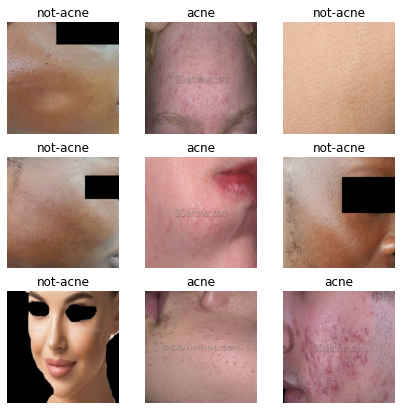

In [8]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Preprocessing and Augumentation

In [9]:
#Resizing is set here for images from user
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ],
    name="Resize_Rescale"
)
#Data Augumentation
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.3, 
                                                 width_factor = 0.3, 
                                                 fill_mode='constant')
    ],
    name="Data_Augmentation",
)

## Augumented Data Visualization

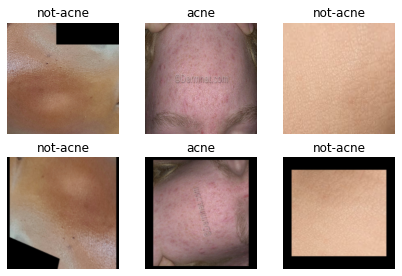

In [10]:
original_images = images[:3]
aug_images = data_augumentation(original_images)
imgs = np.vstack((original_images.numpy(),aug_images.numpy()))

plt.figure(figsize=(7, 7))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# The ViT Architecture

## Defining Patches Class as a Keras Layer

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
      
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
        })
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Patches Visualization

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


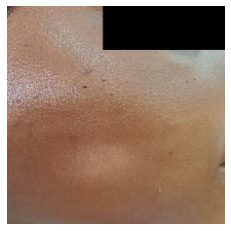

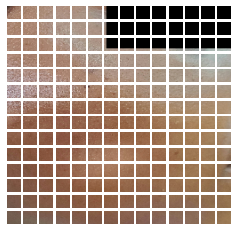

In [12]:
patches = Patches(PATCH_SIZE)(images)

print(f"Image size: {IMG_SIZE} X {IMG_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

plt.figure(figsize=(4, 4))
plt.imshow(images[0].numpy().astype("uint8"))
plt.axis("off")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Class to transform Patches and Add Positional Information


In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=self.projection_dim
        )
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim":self.projection_dim,
            "projection": self.projection,
            "position_embedding": self.position_embedding,
        })
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Defining the MultiLayer Perceptron

In [14]:
def mlp(x, hidden_layers, dropout_rate=0):
    for hidden_layer in hidden_layers:
        x = layers.Dense(hidden_layer, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# ViT Classifier

## Latest ViT

In [15]:
# Creating Keras ViT model using Keras FunctionalAPI
def vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Data Augumentation and Preprocessing
    resize_rescale_images = resize_rescale(inputs)
    augmented = data_augumentation(resize_rescale_images)
    # Split Image into Patches
    patches = Patches(PATCH_SIZE)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, projection_dim)(patches)
    patch_embeddings = encoded_patches
    # Create multiple layers of the Transformer Encoder block.
    for _ in range(transformer_blocks):
      #Loop Over Number of MHA Layer
      for _ in range(mha_blocks):
        #Normalization
        norm = layers.LayerNormalization(epsilon=1e-6)(patch_embeddings)
        # Multi-head attention Layer.
        attention_output = layers.MultiHeadAttention(
                num_heads=attn_heads,
                key_dim=projection_dim,
            )(norm, norm)
        # Skip connection.
        patch_embeddings = layers.Add()([attention_output, patch_embeddings])
      # Normalize data From MHA BLocks
      norm_x2 = layers.LayerNormalization(epsilon=1e-6)(patch_embeddings) 
      # MLP.
      mlp_head = mlp(norm_x2,
                     hidden_layers=transformer_units,
                     dropout_rate=0.1)
      # Skip Connection.
      encoder_block_output = layers.Add()([mlp_head, patch_embeddings])
      patch_embeddings = encoder_block_output

    # Final Normalization.
    #final_norm = layers.LayerNormalization(epsilon=1e-6)(patch_embeddings)
    # Flatten Encoder Outputs
    flattened_outputs = layers.Flatten()(patch_embeddings)
    #flattened_outputs = layers.Dropout(0.5)(flattened_outputs)
    
    # FInal MLP.
    features = mlp(flattened_outputs,
                   hidden_layers=mlp_head_units,
                   dropout_rate=0.2)
    # Classify outputs.
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## Past ViT

In [16]:
# Creating Keras ViT model using Keras FunctionalAPI
def past_vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Data Augumentation and Preprocessing
    resize_rescale_images = resize_rescale(inputs)
    augmented = data_augumentation(resize_rescale_images)
    # Create patches.
    patches = Patches(PATCH_SIZE)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_blocks):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=attn_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_layers=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_layers=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


# Train and Test

## Train Model Function

In [17]:
def train_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_FILEPATH,
        monitor="val_accuracy",
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint_callback],
    )
    return history



## Test Model Function

In [18]:
def test_model(model):
  loss, accuracy = model.evaluate(test_ds)
  print(f"Test Loss: {round(loss * 100, 2)}%")
  print(f"Test Accuracy: {round(accuracy * 100, 2)}%")

## Train

In [19]:
vit_classifier = vit_classifier()
vit_classifier.build(INPUT_SHAPE)
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Resize_Rescale (Sequential)    (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Data_Augmentation (Sequential)  (None, 224, 224, 3)  7          ['Resize_Rescale[0][0]']         
                                                                                                  
 patches_1 (Patches)            (None, None, 768)    0           ['Data_Augmentation[0][0]']  

In [20]:
train_history = train_model(vit_classifier)

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 7.5626 - accuracy: 0.5146
Epoch 1: val_accuracy improved from -inf to 0.41406, saving model to ../Model_Checkpoints/checkpoint12.ckpt
15/15 [==============================] - 48s 3s/step - loss: 7.5626 - accuracy: 0.5146 - val_loss: 1.9798 - val_accuracy: 0.4141
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.9015 - accuracy: 0.5646
Epoch 2: val_accuracy improved from 0.41406 to 0.78125, saving model to ../Model_Checkpoints/checkpoint12.ckpt
15/15 [==============================] - 2s 115ms/step - loss: 0.9015 - accuracy: 0.5646 - val_loss: 0.5303 - val_accuracy: 0.7812
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.6125
Epoch 3: val_accuracy improved from 0.78125 to 0.79688, saving model to ../Model_Checkpoints/checkpoint12.ckpt
15/15 [==============================] - 2s 112ms/step - loss: 0.7091 - accuracy: 0.6125 - val_loss: 0.5787 - val_accuracy: 0.79

## Model Evaluation

In [21]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

Text(0.5, 1.0, 'Training vs Validation Loss')

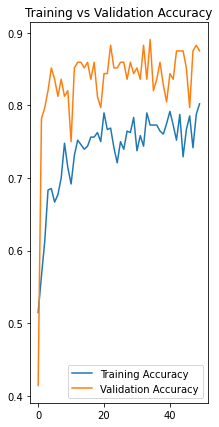

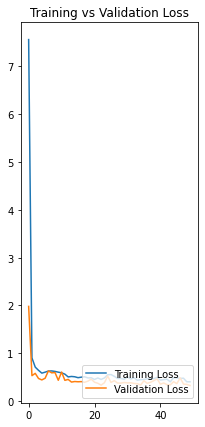

In [22]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.figure(figsize=(7,7))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label ='Training Loss')
plt.plot(range(EPOCHS), val_loss, label ='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training vs Validation Loss')

## Model Test

In [23]:
vit_classifier.load_weights(CHECKPOINT_FILEPATH)
model = vit_classifier
test_model(model)

3/3 [==============================] - 8s 31ms/step - loss: 0.2618 - accuracy: 0.9143
Test Loss: 26.18%
Test Accuracy: 91.43%


In [24]:
def prediction_eval(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array,0)

  prediction = model.predict(img_array)

  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100*(np.max(prediction[0])),2)
  return predicted_class, confidence

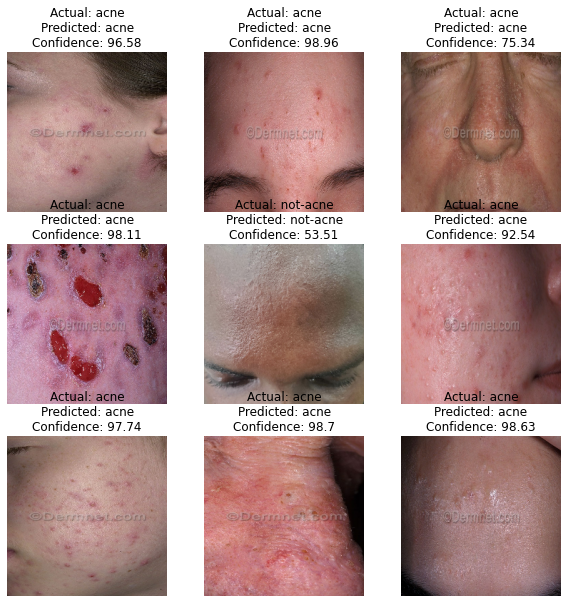

In [25]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = prediction_eval(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}")
    plt.axis('off')

# Saving Model

In [26]:
vit_classifier.save(f"{MODEL_FILEPATH}/{MODEL_VERSION}/{MODEL_VERSION}.h5")
vit_classifier.save_weights(f"{MODEL_FILEPATH}/{MODEL_VERSION}/{MODEL_VERSION}_weights.h5")

In [27]:
model_json = vit_classifier.to_json()
with open(f"{MODEL_FILEPATH}/{MODEL_VERSION}/{MODEL_VERSION}_json.json", "w") as json_file:
    json_file.write(model_json)